# Laboratorio 1 Fundamentos de Aprendizaje Profundo

Nombre: Antonina Arriagada

### 1. Definiciones e importación librerias

In [2]:
import torch
import torch.nn as nn
import time
import sys
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [367]:
def set_seed(seed=43):
    random.seed(seed)  # Semilla para la aleatoriedad de Python
    np.random.seed(seed)  # Semilla para NumPy
    torch.manual_seed(seed)  # Semilla para PyTorch en CPU
    torch.cuda.manual_seed(seed)  # Semilla para PyTorch en GPU
    torch.cuda.manual_seed_all(seed)  # Semilla para todas las GPUs (si tienes múltiples)
    torch.backends.cudnn.deterministic = True  # Garantiza determinismo en convoluciones
    torch.backends.cudnn.benchmark = False  # Desactiva optimizaciones no deterministas
set_seed(43)

#### 1.1 Definición de la red

In [ ]:
class SimpleFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1):
        super(SimpleFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        return torch.sigmoid(self.fc3(h2))
    
    def num_parameters(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total

#### 1.2 Definición de dataset y preprocesamiento de datos

RandomDataset

In [45]:
class RandomDataSet(Dataset):
    def __init__(self, N, f):
        R_N_f = torch.rand(N, f)
        self.X = torch.bernoulli(R_N_f)
        R_N_1 = torch.rand(N, 1)
        self.Y = torch.bernoulli(R_N_1)
        self.num_features = f

    def __len__(self):
        return self.X.size()[0]

    def __getitem__(self, i):
        # Asegúrate de devolver valores en el rango [0, 1]
        X_normalized = self.X[i]
        Y_normalized = self.Y[i]
        return X_normalized, Y_normalized


Dataset de clasificación binaria

In [6]:
weather_data = pd.read_csv("dataset/weather.csv")
weather_data.describe()


,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,25000.000000,24669.000000,24824.000000,24721.000000,9432.000000,6664.000000,21545.000000,24428.000000,23770.000000,24609.000000,23936.000000,20172.000000,20173.000000,14136.000000,13815.000000,24755.000000,24082.000000,25000.000000
mean,12499.500000,13.294568,23.990558,2.674467,5.825138,7.811945,37.772755,12.686917,16.837106,69.822951,52.762826,1018.173290,1015.627438,4.251556,4.409265,17.953084,22.507171,2.677376
std,7217.022701,5.848304,6.114348,9.720306,4.871567,3.718698,13.212331,9.136115,9.095719,17.755908,21.210121,6.481112,6.394829,2.968785,2.719235,5.394685,5.954540,9.705604
min,0.000000,-3.300000,6.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,980.500000,979.000000,0.000000,0.000000,0.300000,6.400000,0.000000
25%,6249.750000,8.900000,19.500000,0.000000,3.000000,5.500000,28.000000,6.000000,9.000000,58.000000,37.000000,1013.800000,1011.300000,1.000000,2.000000,14.200000,18.100000,0.000000
50%,12499.500000,14.000000,23.400000,0.000000,4.800000,8.900000,35.000000,11.000000,17.000000,71.000000,54.000000,1018.200000,1015.700000,5.000000,5.000000,18.400000,21.900000,0.000000
75%,18749.250000,17.900000,27.700000,0.600000,7.200000,10.600000,46.000000,19.000000,22.000000,83.000000,68.000000,1022.600000,1020.000000,7.000000,7.000000,21.900000,26.100000,0.800000
max,24999.000000,29.700000,47.300000,371.000000,86.200000,14.000000,135.000000,130.000000,83.000000,100.000000,100.000000,1039.900000,1036.800000,8.000000,8.000000,37.700000,46.700000,371.000000


In [7]:
print(weather_data.columns)


Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow'],
      dtype='object')


In [8]:
from sklearn.preprocessing import StandardScaler

weather_data.drop(columns=['Unnamed: 0', 'Date'], inplace=True)

numeric_columns = weather_data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = weather_data.select_dtypes(include=['object']).columns

# Se llenan espacios vacíos
weather_data[numeric_columns] = weather_data[numeric_columns].fillna(weather_data[numeric_columns].median())

# se conviertes las variables categóricas en columnas binarias
weather_data = weather_data.apply(lambda x: x.fillna(x.mode()[0]) if x.name in categorical_columns else x)
weather_data = pd.get_dummies(weather_data, columns=['WindGustDir', 'WindDir9am', 'WindDir3pm', 'Location'])

Los datos numéricos se están escalando y normalizando utilizando el método StandardScaler de sklearn, que ajusta cada característica numérica a fin de  tener una media de 0 y una desviación estándar de 1.

In [9]:
scaler = StandardScaler() 
weather_data[numeric_columns] = scaler.fit_transform(weather_data[numeric_columns])

MNIST

In [10]:
from torchvision import datasets, transforms

#  normalización de las imágenes en escala de grises, centrándolas en un valor medio de 0 y escalándolas para que los valores estén entre -1 y 1.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./dataset', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./dataset', train=False, download=True, transform=transform)


In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


In [12]:
images, labels = next(iter(train_loader))
print(f'Batch images shape: {images.shape}, Batch labels shape: {labels.shape}')

Batch images shape: torch.Size([64, 1, 28, 28]), Batch labels shape: torch.Size([64])


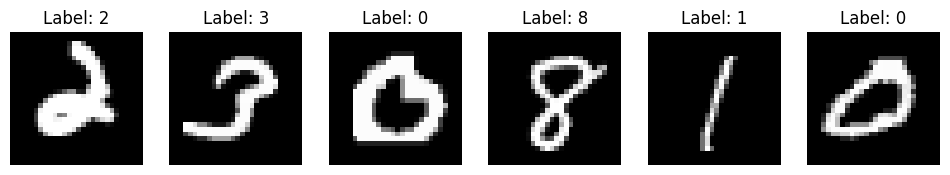

In [13]:
images = images * 0.5 + 0.5 

fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray') 
    axes[i].set_title(f'Label: {labels[i].item()}')
    axes[i].axis('off')
plt.show()

### 2. Inicialización de pesos

El estudiante debe documentar las observaciones sobre cómo la inicialización 
de los pesos y la normalización de los datos afectan la estabilidad del 
entrenamiento, la rapidez de la convergencia y el rendimiento final del modelo.

Inicialización de Xavier (o Glorot): Ideal para redes con funciones de 
activación simétricas como tanh o sigmoid, y mejora la propagación de 
los gradientes en redes profundas.

Inicialización de He: Recomendada para redes con funciones de 
activación como ReLU, ya que ayuda a manejar el problema del 
desvanecimiento de gradientes.

Sugerencia de análisis: Comparar los resultados obtenidos con cada 
optimizador e inicialización utilizando métricas como la pérdida de 
entrenamiento y precisión, además de visualizar las curvas de aprendizaje 
para cada configuración.

#### 2.1 Inicialización de Xavier

La inicialización de Xavier (también conocida como Glorot) se usa típicamente con activaciones sigmoides o tangentes hiperbólicas (tanh). La función de Xavier ajusta los pesos para que sigan una distribución uniforme o normal con una varianza específica que ayuda a estabilizar la activación en cada capa.

In [15]:
def init_xavier(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight) 
            if layer.bias is not None:
                nn.init.zeros_(layer.bias) 

#### 2.2 Inicialización de He

La inicialización de He es ideal cuando se utilizan activaciones ReLU o variantes de ReLU, ya que adapta la varianza de los pesos a la cantidad de neuronas en la capa anterior, ayudando a que las activaciones no se saturen ni se apaguen.

In [16]:
def init_he(model):
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu') 
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

### 3. Optimización

Algoritmos de optimización

##### 3.1 SGD (Descenso de Gradiente Estocástico)

In [17]:
def get_sgd_optimizer(model, lr=0.01):
    """SGD Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr)

##### 3.2 SGD con Momentum

In [18]:
def get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9):
    """SGD with Momentum Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

##### 3.3 SGD con Nesterov Momentum

In [19]:
def get_sgd_nesterov_optimizer(model, lr=0.01, momentum=0.9):
    """SGD with Nesterov Momentum Optimizer"""
    return torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

##### 3.4 RMSProp

In [20]:
def get_rmsprop_optimizer(model, lr=0.01, alpha=0.99):
    """RMSProp Optimizer"""
    return torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha)

##### 3.5 Adam

In [21]:
def get_adam_optimizer(model, lr=0.01, betas=(0.9, 0.999)):
    """Adam Optimizer"""
    return torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

### 4. Regularización

##### 4.1 Dropout

Dropout ayuda a reducir el sobreajuste apagando aleatoriamente ciertas unidades durante el entrenamiento. Puedes definir una función que añada capas de dropout a un modelo

In [47]:
class DropoutFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, dropout_rate=0.5):
        super(DropoutFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h1 = self.dropout1(h1)
        h2 = torch.relu(self.fc2(h1))
        h2 = self.dropout2(h2)
        return torch.sigmoid(self.fc3(h2))

##### 4.2 Batch Normalization

Batch Normalization se puede aplicar a las capas de manera similar. Esto ayuda a estabilizar el entrenamiento al mantener las activaciones de cada capa en un rango adecuado.

In [49]:
class BatchNormFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1):
        super(BatchNormFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        h1 = torch.relu(self.bn1(self.fc1(x)))
        h2 = torch.relu(self.bn2(self.fc2(h1)))
        return torch.sigmoid(self.fc3(h2))


##### 4.3 Batch Normalization con Dropout

In [304]:
class BatchNormDropoutFFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size=1, p1=0.3, p2=0.5):
        super(BatchNormDropoutFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=p1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=p2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        h1 = torch.relu(self.dropout1(self.bn1(self.fc1(x))))
        h2 = torch.relu(self.dropout2(self.bn2(self.fc2(h1))))
        return torch.sigmoid(self.fc3(h2))


##### 4.4 Regularización L2

La regularización L2 (también llamada decaimiento de peso) se puede agregar directamente en el optimizador, y su valor será aplicado a cada parámetro del modelo.

In [305]:
def l2_regularization(model, lambda_l2):
    l2_norm = sum(param.pow(2.0).sum() for param in model.parameters())
    return lambda_l2 * l2_norm

### 5. Implementación del modelo

Se define una función para graficar las curvas de pérdida de entrenamiento y validación.

In [306]:
def plot_loss_curves(train_losses, val_losses, title="Loss Curves"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [307]:
def plot_acc_curves(train_losses, val_losses, title="Accuracy Curves"):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Accuracy', marker='o')
    plt.plot(val_losses, label='Validation Accuracy', marker='o', linestyle='--')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

##### 5.1 Random Dataset

Entrenamiento del modelo:

In [322]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            predictions = (outputs > 0.5).float() 
            correct_train += (predictions == targets).sum().item()
            total_train += targets.size(0)
        
        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        epoch_val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                correct_val += (predictions == targets).sum().item()
                total_val += targets.size(0)
        
        val_losses.append(epoch_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, "
              f"Training Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


División del dataset en train - validation y test según 70%-15%-15%

In [310]:
total_samples = 1000
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = total_samples - train_size - val_size
dataset = RandomDataSet(N=total_samples, f=10)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [343]:
for i in range(10):
    features, target = dataset[i]
    print(f"Features: {features.numpy()}, Target: {target.item()}")

Features: [1. 0. 0. 0. 0. 0. 1. 0. 1. 1.], Target: 0.0
Features: [0. 1. 1. 1. 0. 0. 1. 0. 0. 1.], Target: 1.0
Features: [0. 1. 0. 1. 1. 1. 1. 0. 1. 0.], Target: 0.0
Features: [0. 0. 1. 0. 1. 1. 0. 0. 1. 1.], Target: 0.0
Features: [1. 0. 0. 1. 1. 0. 0. 0. 1. 0.], Target: 1.0
Features: [1. 1. 0. 0. 1. 1. 0. 1. 0. 0.], Target: 0.0
Features: [1. 1. 0. 0. 0. 1. 1. 0. 0. 1.], Target: 1.0
Features: [1. 0. 1. 1. 1. 0. 1. 1. 0. 1.], Target: 1.0
Features: [1. 1. 0. 1. 1. 0. 1. 1. 1. 0.], Target: 0.0
Features: [0. 0. 0. 0. 1. 0. 1. 1. 1. 1.], Target: 0.0


In [340]:
data = [dataset[i] for i in range(len(dataset))]
features = [item[0].numpy() for item in data]
targets = [item[1].item() for item in data]
df = pd.DataFrame(features, columns=[f'Feature_{i+1}' for i in range(dataset.num_features)])
df['Target'] = targets
print(df.head())

   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0        1.0        0.0        0.0        0.0        0.0        0.0   
1        0.0        1.0        1.0        1.0        0.0        0.0   
2        0.0        1.0        0.0        1.0        1.0        1.0   
3        0.0        0.0        1.0        0.0        1.0        1.0   
4        1.0        0.0        0.0        1.0        1.0        0.0   

   Feature_7  Feature_8  Feature_9  Feature_10  Target  
0        1.0        0.0        1.0         1.0     0.0  
1        1.0        0.0        0.0         1.0     1.0  
2        1.0        0.0        1.0         0.0     0.0  
3        0.0        0.0        1.0         1.0     0.0  
4        0.0        0.0        1.0         0.0     1.0  


In [344]:
for i in range(5):
    features, target = train_dataset[i]
    print(f"Training Sample {i+1} - Features: {features.numpy()}, Target: {target.item()}")

Training Sample 1 - Features: [1. 0. 1. 1. 0. 0. 1. 0. 1. 0.], Target: 1.0
Training Sample 2 - Features: [0. 0. 0. 1. 1. 1. 0. 0. 1. 1.], Target: 0.0
Training Sample 3 - Features: [1. 1. 0. 0. 0. 0. 1. 0. 0. 1.], Target: 0.0
Training Sample 4 - Features: [1. 0. 0. 0. 0. 1. 1. 0. 1. 1.], Target: 0.0
Training Sample 5 - Features: [1. 1. 0. 0. 0. 0. 0. 1. 0. 0.], Target: 0.0


Se definen lotes de cada subconjunto, organiza los datasets en lotes de tamaño 64 y los configura para su uso durante el entrenamiento, validación y prueba.

In [311]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(43))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1/50, Training Loss: 0.7056, Validation Loss: 0.6943, Training Accuracy: 0.4957, Validation Accuracy: 0.5200
Epoch 2/50, Training Loss: 0.7030, Validation Loss: 0.6916, Training Accuracy: 0.4929, Validation Accuracy: 0.5467
Epoch 3/50, Training Loss: 0.7007, Validation Loss: 0.6895, Training Accuracy: 0.4971, Validation Accuracy: 0.5400
Epoch 4/50, Training Loss: 0.6989, Validation Loss: 0.6877, Training Accuracy: 0.5043, Validation Accuracy: 0.5400
Epoch 5/50, Training Loss: 0.6973, Validation Loss: 0.6862, Training Accuracy: 0.5214, Validation Accuracy: 0.5467
Epoch 6/50, Training Loss: 0.6963, Validation Loss: 0.6850, Training Accuracy: 0.5286, Validation Accuracy: 0.5667
Epoch 7/50, Training Loss: 0.6952, Validation Loss: 0.6840, Training Accuracy: 0.5286, Validation Accuracy: 0.5533
Epoch 8/50, Training Loss: 0.6940, Validation Loss: 0.6832, Training Accuracy: 0.5314, Validation Accuracy: 0.5533
Epoch 9/50, Training Loss: 0.6936, Validation Loss: 0.6826, Training Accuracy: 0

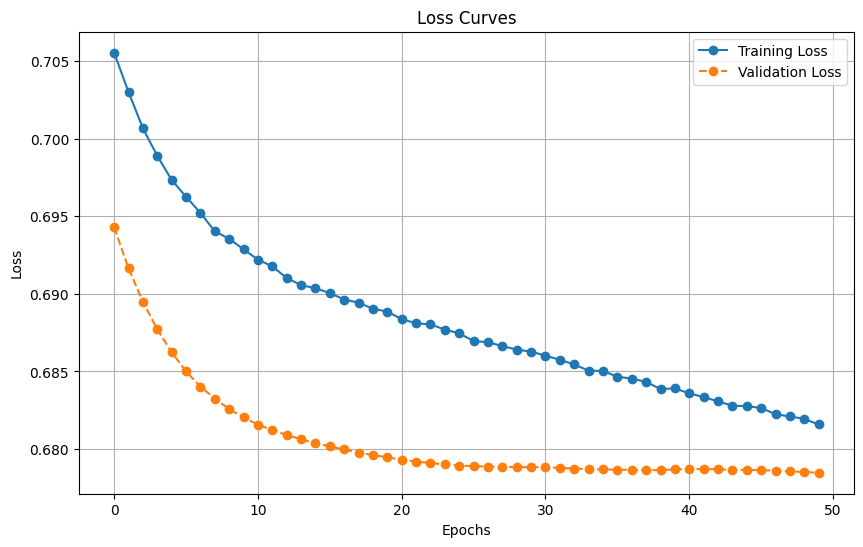

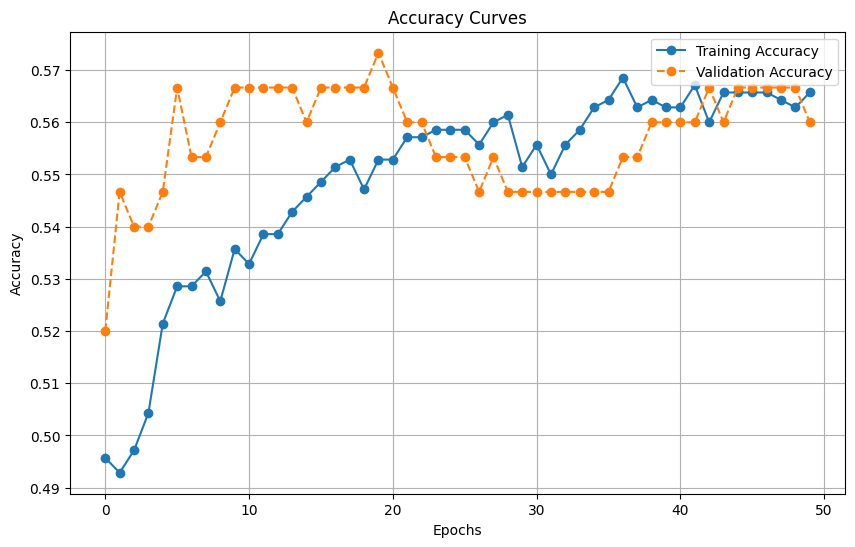

In [411]:
input_size = dataset.num_features 
hidden_size1 = 16 
hidden_size2 = 8 
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.01)
criterion = nn.BCELoss()
init_xavier(model)  
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Epoch 1/50, Training Loss: 0.8081, Validation Loss: 0.7637, Training Accuracy: 0.4843, Validation Accuracy: 0.4800
Epoch 2/50, Training Loss: 0.7683, Validation Loss: 0.7321, Training Accuracy: 0.4900, Validation Accuracy: 0.5267
Epoch 3/50, Training Loss: 0.7436, Validation Loss: 0.7128, Training Accuracy: 0.5100, Validation Accuracy: 0.5267
Epoch 4/50, Training Loss: 0.7286, Validation Loss: 0.7005, Training Accuracy: 0.5257, Validation Accuracy: 0.5800
Epoch 5/50, Training Loss: 0.7183, Validation Loss: 0.6926, Training Accuracy: 0.5429, Validation Accuracy: 0.5467
Epoch 6/50, Training Loss: 0.7118, Validation Loss: 0.6874, Training Accuracy: 0.5371, Validation Accuracy: 0.5333
Epoch 7/50, Training Loss: 0.7066, Validation Loss: 0.6841, Training Accuracy: 0.5357, Validation Accuracy: 0.5533
Epoch 8/50, Training Loss: 0.7038, Validation Loss: 0.6818, Training Accuracy: 0.5386, Validation Accuracy: 0.5800
Epoch 9/50, Training Loss: 0.7012, Validation Loss: 0.6803, Training Accuracy: 0

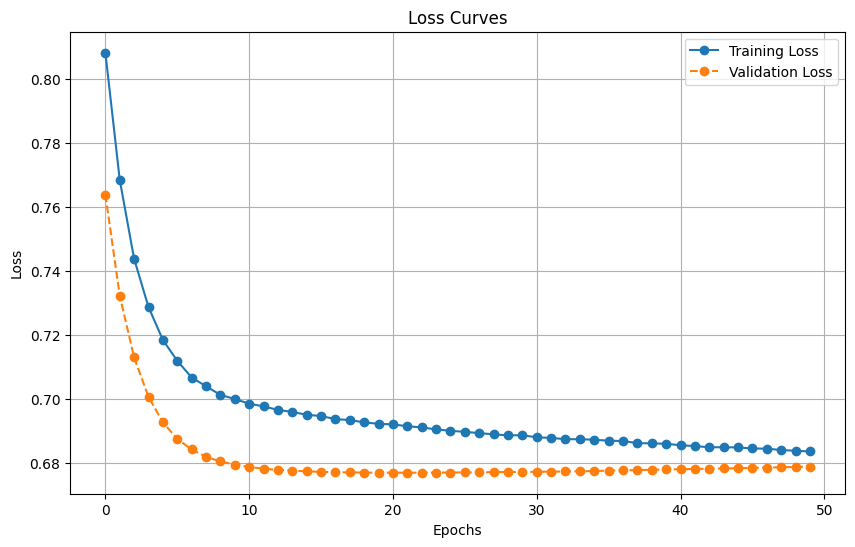

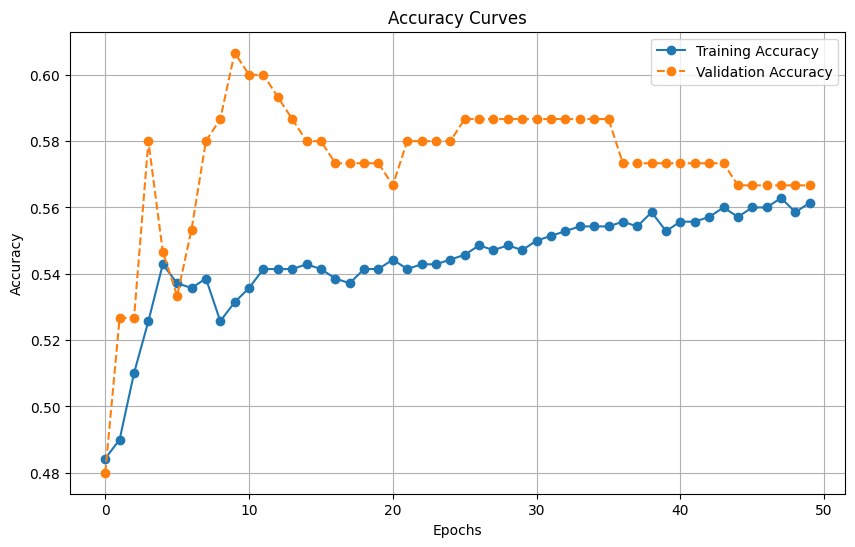

In [421]:
input_size = dataset.num_features 
hidden_size1 = 16 
hidden_size2 = 8 
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size) 
optimizer = get_sgd_optimizer(model, lr=0.01)
criterion = nn.BCELoss()
init_he(model)  
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Observaciones de la gráfica
Descenso inicial más pronunciado:

La pérdida de entrenamiento y validación disminuyen rápidamente en las primeras épocas. Esto es típico de la inicialización He, que está diseñada para redes con activaciones ReLU. Facilita un flujo de gradientes más estable en capas profundas y mejora el aprendizaje inicial.
Pérdida de validación más baja que la de entrenamiento:

Este comportamiento es normal y podría deberse a:
Regularización inherente: Si usas técnicas como Dropout o L2, penalizan la pérdida de entrenamiento, pero no afectan la validación.
División favorable de datos: Si los ejemplos en el conjunto de validación son más fáciles de predecir que los de entrenamiento.
Convergencia más rápida:

La pérdida tanto de entrenamiento como de validación tienden a estabilizarse más rápido en comparación con otros métodos de inicialización, lo cual es uno de los beneficios de He Initialization.

Con init_xavier:

Las pérdidas disminuyen más lentamente y las curvas suelen ser más suaves. Esto es porque Xavier está diseñado para mantener la varianza de las activaciones uniforme entre capas, pero no está optimizado específicamente para ReLU.
Con init_he:

Un descenso más rápido de la pérdida y mejores resultados iniciales. Esto se debe a que He Initialization ajusta la varianza para tener en cuenta la naturaleza de ReLU, que "apaga" neuronas con valores negativos.

Utilizar init_he si usas ReLU:

Es evidente que He Initialization da mejores resultados iniciales con ReLU. Si tu modelo usa esta activación, esta inicialización será la opción más adecuada.

#### Prueba de optimizadores

In [431]:
optimizers_to_test = [
    ("SGD", lambda model: get_sgd_optimizer(model, lr=0.01)),
    ("SGD + Momentum", lambda model: get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9)),
    ("SGD + Nesterov", lambda model: get_sgd_nesterov_optimizer(model, lr=0.01, momentum=0.9)),
    ("RMSProp", lambda model: get_rmsprop_optimizer(model, lr=0.01, alpha=0.99)),
    ("Adam", lambda model: get_adam_optimizer(model, lr=0.01, betas=(0.9, 0.999)))
]

In [432]:
results_df = []
optimizer_results = []
for opt_name, opt_fn in optimizers_to_test:
    print(f"Testing optimizer: {opt_name}")
    model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
    init_he(model)
    optimizer = opt_fn(model)
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=50
    )
    optimizer_results.append({
        "Optimizer": opt_name,
        "Final Train Loss": train_losses[-1],
        "Final Val Loss": val_losses[-1],
        "Final Train Accuracy": train_accuracies[-1],
        "Final Val Accuracy": val_accuracies[-1]
    })
results_df = pd.DataFrame(optimizer_results)

Testing optimizer: SGD
Epoch 1/50, Training Loss: 0.7017, Validation Loss: 0.6939, Training Accuracy: 0.5186, Validation Accuracy: 0.5467
Epoch 2/50, Training Loss: 0.7012, Validation Loss: 0.6937, Training Accuracy: 0.5200, Validation Accuracy: 0.5267
Epoch 3/50, Training Loss: 0.7005, Validation Loss: 0.6934, Training Accuracy: 0.5229, Validation Accuracy: 0.5333
Epoch 4/50, Training Loss: 0.7001, Validation Loss: 0.6932, Training Accuracy: 0.5186, Validation Accuracy: 0.5400
Epoch 5/50, Training Loss: 0.6997, Validation Loss: 0.6930, Training Accuracy: 0.5100, Validation Accuracy: 0.5400
Epoch 6/50, Training Loss: 0.6994, Validation Loss: 0.6928, Training Accuracy: 0.5114, Validation Accuracy: 0.5400
Epoch 7/50, Training Loss: 0.6992, Validation Loss: 0.6927, Training Accuracy: 0.5057, Validation Accuracy: 0.5467
Epoch 8/50, Training Loss: 0.6988, Validation Loss: 0.6925, Training Accuracy: 0.5071, Validation Accuracy: 0.5467
Epoch 9/50, Training Loss: 0.6983, Validation Loss: 0.692

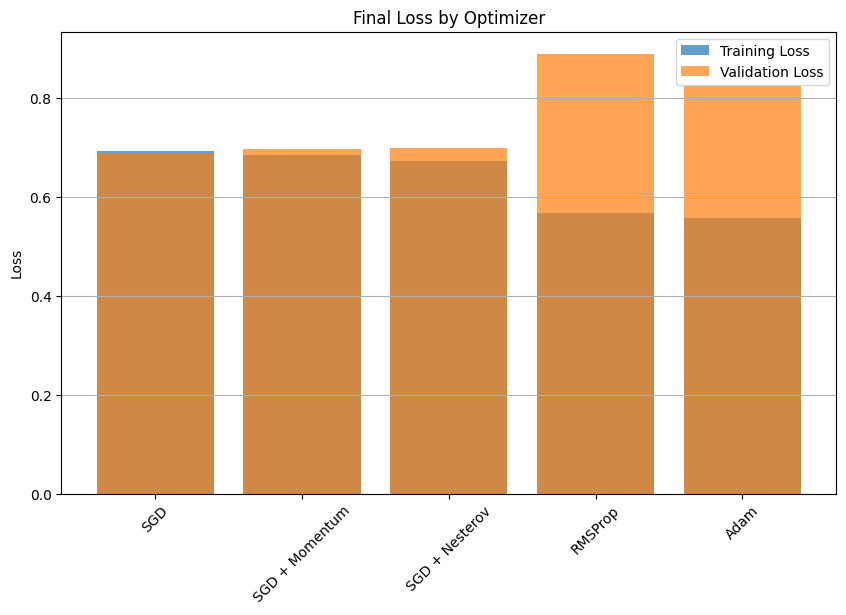

In [433]:
plt.figure(figsize=(10, 6))
plt.bar(results_df["Optimizer"], results_df["Final Train Loss"], label="Training Loss", alpha=0.7)
plt.bar(results_df["Optimizer"], results_df["Final Val Loss"], label="Validation Loss", alpha=0.7)
plt.title("Final Loss by Optimizer")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y")
plt.show()

SGD + Momentum y SGD + Nesterov parecen tener menores pérdidas finales en comparación con otros optimizadores.
Adam y RMSProp tienen pérdidas de validación más altas, lo que podría indicar sobreajuste o un mal ajuste al dataset.

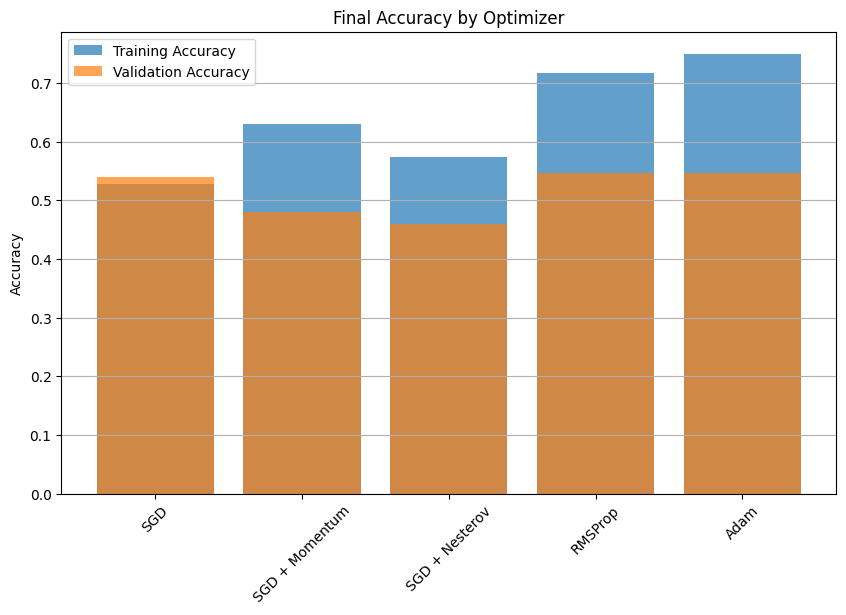

In [106]:
plt.figure(figsize=(10, 6))
plt.bar(results_df["Optimizer"], results_df["Final Train Accuracy"], label="Training Accuracy", alpha=0.7)
plt.bar(results_df["Optimizer"], results_df["Final Val Accuracy"], label="Validation Accuracy", alpha=0.7)
plt.title("Final Accuracy by Optimizer")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y")
plt.show()

Adam y SGD + Nesterov tienen las precisiones más altas, tanto en entrenamiento como en validación.
SGD sin mejoras (momentum o Nesterov) tiene la precisión más baja, mostrando que los métodos básicos de optimización pueden necesitar ajustes adicionales.

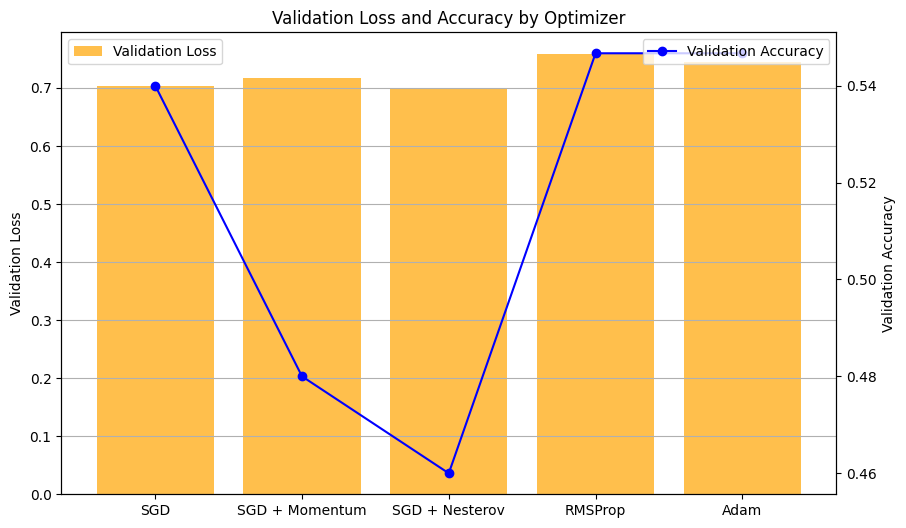

In [107]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Pérdida final
ax1.bar(results_df["Optimizer"], results_df["Final Val Loss"], alpha=0.7, color="orange", label="Validation Loss")
ax1.set_ylabel("Validation Loss")
ax1.set_title("Validation Loss and Accuracy by Optimizer")
ax1.legend(loc="upper left")
ax1.grid(axis="y")

# Precisión final (segundo eje)
ax2 = ax1.twinx()
ax2.plot(results_df["Optimizer"], results_df["Final Val Accuracy"], color="blue", marker="o", label="Validation Accuracy")
ax2.set_ylabel("Validation Accuracy")
ax2.legend(loc="upper right")

plt.xticks(rotation=45)
plt.show()

Una pérdida de validación más baja no siempre garantiza una mayor precisión.
En este caso, SGD + Momentum logra un buen equilibrio entre pérdida y precisión.


Mejor optimizador general: SGD + Momentum parece ser un buen candidato, logrando un balance entre pérdida y precisión.
Rendimiento de Adam: Aunque tiene buenas precisiones, su pérdida de validación alta puede ser una señal de sobreajuste.
SGD básico: Tiene un rendimiento menor en comparación con sus versiones mejoradas (Momentum y Nesterov).

Epoch 1/20, Training Loss: 1.1989, Validation Loss: 0.7068, Training Accuracy: 0.5029, Validation Accuracy: 0.5533
Epoch 2/20, Training Loss: 0.7561, Validation Loss: 0.7580, Training Accuracy: 0.5214, Validation Accuracy: 0.5200
Epoch 3/20, Training Loss: 0.7251, Validation Loss: 0.6795, Training Accuracy: 0.5343, Validation Accuracy: 0.5533
Epoch 4/20, Training Loss: 0.6896, Validation Loss: 0.6718, Training Accuracy: 0.5786, Validation Accuracy: 0.5867
Epoch 5/20, Training Loss: 0.6845, Validation Loss: 0.6719, Training Accuracy: 0.5771, Validation Accuracy: 0.5800
Epoch 6/20, Training Loss: 0.6827, Validation Loss: 0.6721, Training Accuracy: 0.5829, Validation Accuracy: 0.5733
Epoch 7/20, Training Loss: 0.6775, Validation Loss: 0.6723, Training Accuracy: 0.5971, Validation Accuracy: 0.5667
Epoch 8/20, Training Loss: 0.6755, Validation Loss: 0.6722, Training Accuracy: 0.5986, Validation Accuracy: 0.5667
Epoch 9/20, Training Loss: 0.6731, Validation Loss: 0.6725, Training Accuracy: 0

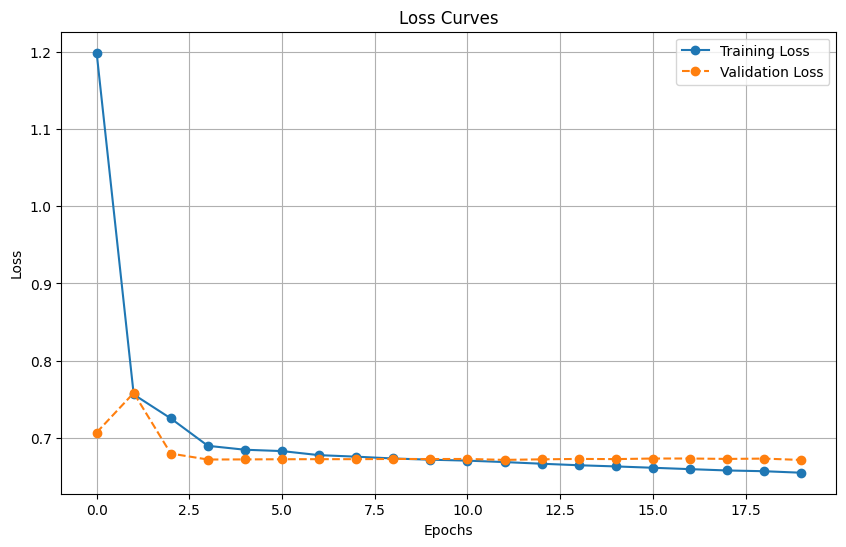

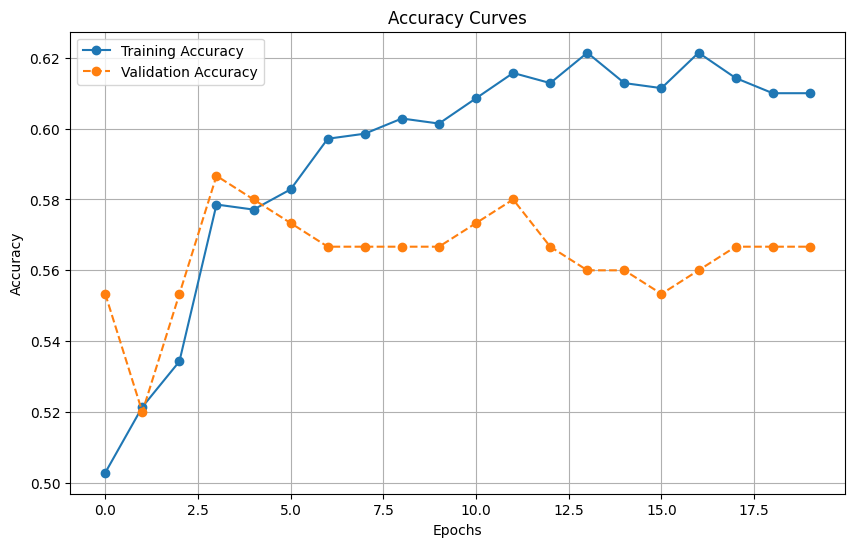

In [120]:
input_size = dataset.num_features 
hidden_size1 = 32 
hidden_size2 = 16 
output_size = 1    
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)  # Inicializar el modelo
optimizer = get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9)
criterion = nn.BCELoss()
init_he(model)  
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves")

Epoch 1/20, Training Loss: 1.0803, Validation Loss: 0.7215, Training Accuracy: 0.4814, Validation Accuracy: 0.5533
Epoch 2/20, Training Loss: 0.8549, Validation Loss: 0.7207, Training Accuracy: 0.5114, Validation Accuracy: 0.5333
Epoch 3/20, Training Loss: 0.7580, Validation Loss: 0.6948, Training Accuracy: 0.5143, Validation Accuracy: 0.5200
Epoch 4/20, Training Loss: 0.7263, Validation Loss: 0.6905, Training Accuracy: 0.4814, Validation Accuracy: 0.5467
Epoch 5/20, Training Loss: 0.7095, Validation Loss: 0.6886, Training Accuracy: 0.5171, Validation Accuracy: 0.5867
Epoch 6/20, Training Loss: 0.7098, Validation Loss: 0.6888, Training Accuracy: 0.5071, Validation Accuracy: 0.5533
Epoch 7/20, Training Loss: 0.6917, Validation Loss: 0.6879, Training Accuracy: 0.5129, Validation Accuracy: 0.5333
Epoch 8/20, Training Loss: 0.7074, Validation Loss: 0.6885, Training Accuracy: 0.4871, Validation Accuracy: 0.5400
Epoch 9/20, Training Loss: 0.6896, Validation Loss: 0.6900, Training Accuracy: 0

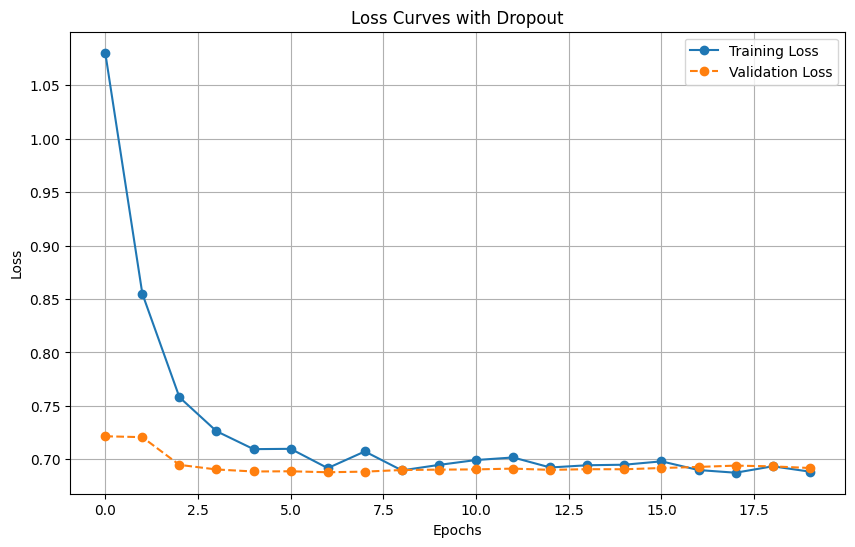

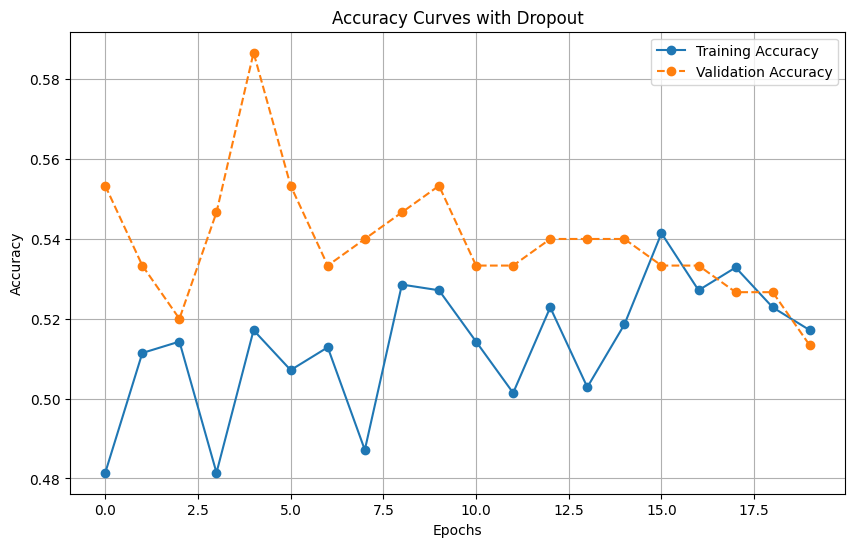

In [122]:
input_size = dataset.num_features 
hidden_size1 = 32 
hidden_size2 = 16 
output_size = 1    

# Crear el modelo y aplicar Dropout
model = DropoutFFNN(input_size=dataset.num_features, hidden_size1=32, hidden_size2=16, output_size=1, dropout_rate=0.5)
init_he(model)  # Inicialización He
optimizer = get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9)
criterion = nn.BCELoss()

# Entrenar el modelo
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with Dropout")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with Dropout")



Análisis de las gráficas:
1. Curvas de pérdida (Loss Curves with Dropout):
Pérdida de entrenamiento:
Comienza alta, como era de esperarse con la introducción de Dropout (que desactiva neuronas durante el entrenamiento), pero desciende rápidamente y converge.
Pérdida de validación:
Se estabiliza más rápido que la de entrenamiento, lo que sugiere que Dropout está ayudando a prevenir sobreajuste.
Tendencia general:
Las curvas son bastante estables después de las primeras épocas, lo que es una buena señal de generalización.
2. Curvas de precisión (Accuracy Curves with Dropout):
Ruido en las curvas:
La precisión muestra bastante variabilidad entre épocas. Esto es típico al usar Dropout, ya que cada iteración activa diferentes subconjuntos de neuronas.
Precisión promedio:
Aunque las fluctuaciones son visibles, el modelo mantiene una precisión razonable tanto en entrenamiento como en validación, con pequeñas diferencias entre ambas.

Epoch 1/20, Training Loss: 0.8715, Validation Loss: 0.7874, Training Accuracy: 0.4886, Validation Accuracy: 0.5200
Epoch 2/20, Training Loss: 0.7597, Validation Loss: 0.7050, Training Accuracy: 0.4943, Validation Accuracy: 0.5333
Epoch 3/20, Training Loss: 0.7296, Validation Loss: 0.6886, Training Accuracy: 0.5086, Validation Accuracy: 0.5200
Epoch 4/20, Training Loss: 0.7110, Validation Loss: 0.6834, Training Accuracy: 0.5300, Validation Accuracy: 0.5267
Epoch 5/20, Training Loss: 0.6983, Validation Loss: 0.6817, Training Accuracy: 0.5571, Validation Accuracy: 0.5400
Epoch 6/20, Training Loss: 0.6957, Validation Loss: 0.6826, Training Accuracy: 0.5486, Validation Accuracy: 0.5533
Epoch 7/20, Training Loss: 0.6906, Validation Loss: 0.6821, Training Accuracy: 0.5471, Validation Accuracy: 0.5667
Epoch 8/20, Training Loss: 0.6904, Validation Loss: 0.6812, Training Accuracy: 0.5514, Validation Accuracy: 0.5800
Epoch 9/20, Training Loss: 0.6878, Validation Loss: 0.6816, Training Accuracy: 0

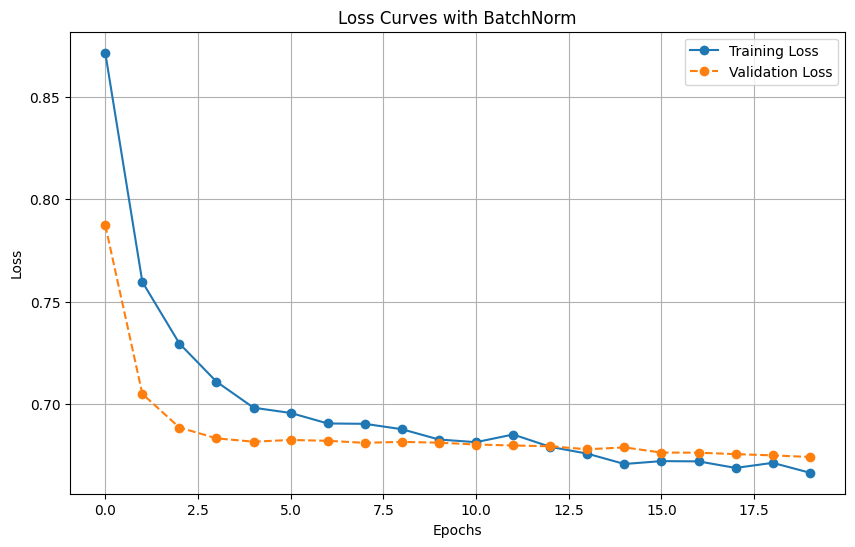

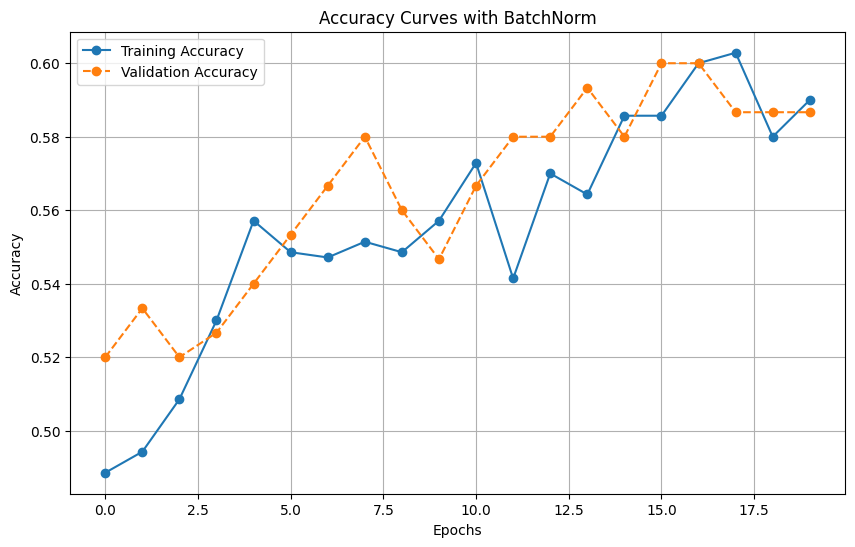

In [126]:
model = BatchNormFFNN(input_size=dataset.num_features, hidden_size1=32, hidden_size2=16, output_size=1)
init_he(model)
optimizer = get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9)
criterion = nn.BCELoss()

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")


Curvas de Pérdida (Loss Curves with BatchNorm):
Pérdida de entrenamiento:
Disminuye progresivamente de forma más suave y consistente en comparación con Dropout. Esto es esperado, ya que BatchNorm estabiliza el entrenamiento.
Pérdida de validación:
Se estabiliza pronto y muestra menos variación que con Dropout, lo que indica que BatchNorm mejora la generalización al normalizar las activaciones intermedias.
Tendencia general:
Aunque la pérdida de validación es ligeramente mayor que la de entrenamiento, las curvas están bastante alineadas, lo cual es una buena señal.


Curvas de Precisión (Accuracy Curves with BatchNorm):
Precisión de entrenamiento:
Muestra una tendencia ascendente clara y consistente, lo que indica que el modelo está aprendiendo de manera estable.
Precisión de validación:
Es menos consistente y más ruidosa que la precisión de entrenamiento, pero no muestra un patrón de sobreajuste significativo.
Tendencia general:
BatchNorm estabiliza el entrenamiento, pero puede no ser suficiente por sí solo para reducir el ruido en la validación.

Comparación con Dropout:
BatchNorm es más efectivo para estabilizar el entrenamiento, como se observa en las curvas de pérdida más suaves y consistentes.
Dropout reduce más el sobreajuste, pero introduce mayor ruido en las métricas.
Validación:
BatchNorm mantiene una pérdida de validación más estable, mientras que Dropout tiende a ser más variable.

Comparación con Dropout:
BatchNorm es más efectivo para estabilizar el entrenamiento, como se observa en las curvas de pérdida más suaves y consistentes.
Dropout reduce más el sobreajuste, pero introduce mayor ruido en las métricas.
Validación:
BatchNorm mantiene una pérdida de validación más estable, mientras que Dropout tiende a ser más variable.

In [ ]:
# Modificar el bucle de entrenamiento para incluir la regularización
def train_model_with_l2(model, criterion, optimizer, train_loader, val_loader, l2_lambda, epochs=20):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss, correct_train, total_train = 0, 0, 0

        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss += l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct_train += (predictions == targets).sum().item()
            total_train += targets.size(0)

        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        epoch_val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                correct_val += (predictions == targets).sum().item()
                total_val += targets.size(0)

        val_losses.append(epoch_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, "
              f"Training Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/20, Training Loss: 0.8601, Validation Loss: 0.6940, Training Accuracy: 0.5014, Validation Accuracy: 0.4933
Epoch 2/20, Training Loss: 0.8551, Validation Loss: 0.6938, Training Accuracy: 0.5057, Validation Accuracy: 0.5067
Epoch 3/20, Training Loss: 0.8486, Validation Loss: 0.6936, Training Accuracy: 0.5086, Validation Accuracy: 0.5000
Epoch 4/20, Training Loss: 0.8418, Validation Loss: 0.6934, Training Accuracy: 0.5186, Validation Accuracy: 0.5133
Epoch 5/20, Training Loss: 0.8352, Validation Loss: 0.6934, Training Accuracy: 0.5229, Validation Accuracy: 0.5133
Epoch 6/20, Training Loss: 0.8288, Validation Loss: 0.6933, Training Accuracy: 0.5257, Validation Accuracy: 0.5067
Epoch 7/20, Training Loss: 0.8229, Validation Loss: 0.6932, Training Accuracy: 0.5257, Validation Accuracy: 0.5333
Epoch 8/20, Training Loss: 0.8170, Validation Loss: 0.6932, Training Accuracy: 0.5229, Validation Accuracy: 0.5267
Epoch 9/20, Training Loss: 0.8116, Validation Loss: 0.6932, Training Accuracy: 0

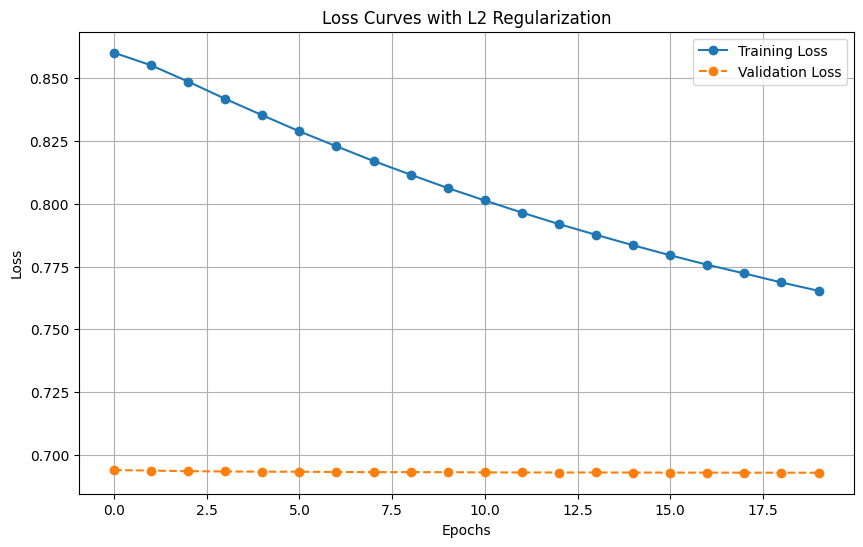

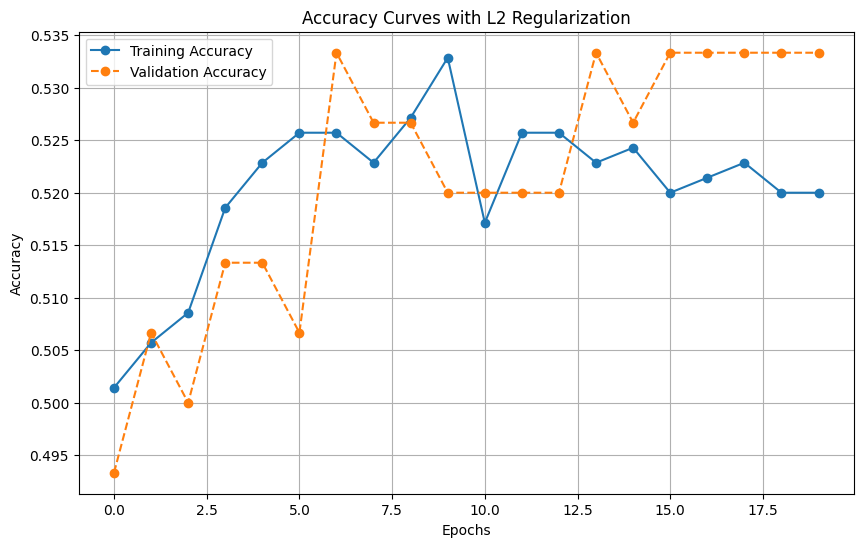

In [158]:
model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
optimizer =get_sgd_momentum_optimizer(model, lr=0.01, momentum=0.9)
l2_lambda = 0.01 
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_l2(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    l2_lambda=l2_lambda,
    epochs=20
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with L2 Regularization")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with L2 Regularization")

Curvas de Pérdida (Loss Curves with L2 Regularization):
Pérdida de entrenamiento:
Disminuye consistentemente, pero a un ritmo más lento en comparación con las otras técnicas. Esto es porque L2 penaliza los pesos grandes, ralentizando la convergencia.
Pérdida de validación:
Se mantiene estable y baja durante todo el entrenamiento, lo que sugiere que L2 está reduciendo el sobreajuste.
Tendencia general:
La regularización L2 ha estabilizado bien la pérdida de validación y parece mantener una generalización decente.

Curvas de Precisión (Accuracy Curves with L2 Regularization):
Precisión de entrenamiento:
Muestra un comportamiento más consistente, aunque con menos crecimiento hacia el final. Esto refleja la penalización de pesos grandes, lo que puede limitar la capacidad del modelo.
Precisión de validación:
La curva es ruidosa y muestra fluctuaciones más grandes en comparación con las otras técnicas, pero la tendencia general es razonablemente estable.
Tendencia general:
Aunque las fluctuaciones son evidentes, L2 ayuda a prevenir sobreajuste, pero podría no ser suficiente para estabilizar completamente la validación.

Comparación con Dropout y BatchNorm:

Dropout:
Más efectivo para reducir el sobreajuste, pero introduce más ruido en el entrenamiento.

BatchNorm:
Ofrece un entrenamiento más estable y rápido, pero podría necesitar ajustes para la validación.

L2 Regularization:
Es el más efectivo para estabilizar la validación, pero limita la capacidad del modelo al penalizar pesos grandes.

In [159]:
def get_sgd_momentum_optimizer_with_l2(model, lr=0.01, momentum=0.9, weight_decay=0.01):
    """SGD con Momentum y penalización L2"""
    return torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )

Epoch 1/20, Training Loss: 0.8158, Validation Loss: 0.7697, Training Accuracy: 0.4843, Validation Accuracy: 0.5133
Epoch 2/20, Training Loss: 0.7635, Validation Loss: 0.7355, Training Accuracy: 0.4886, Validation Accuracy: 0.4933
Epoch 3/20, Training Loss: 0.7309, Validation Loss: 0.7202, Training Accuracy: 0.4929, Validation Accuracy: 0.5133
Epoch 4/20, Training Loss: 0.7118, Validation Loss: 0.7142, Training Accuracy: 0.5057, Validation Accuracy: 0.5000
Epoch 5/20, Training Loss: 0.7023, Validation Loss: 0.7104, Training Accuracy: 0.5114, Validation Accuracy: 0.4800
Epoch 6/20, Training Loss: 0.6992, Validation Loss: 0.7091, Training Accuracy: 0.5243, Validation Accuracy: 0.4667
Epoch 7/20, Training Loss: 0.6946, Validation Loss: 0.7076, Training Accuracy: 0.5271, Validation Accuracy: 0.4667
Epoch 8/20, Training Loss: 0.6929, Validation Loss: 0.7066, Training Accuracy: 0.5343, Validation Accuracy: 0.4733
Epoch 9/20, Training Loss: 0.6922, Validation Loss: 0.7062, Training Accuracy: 0

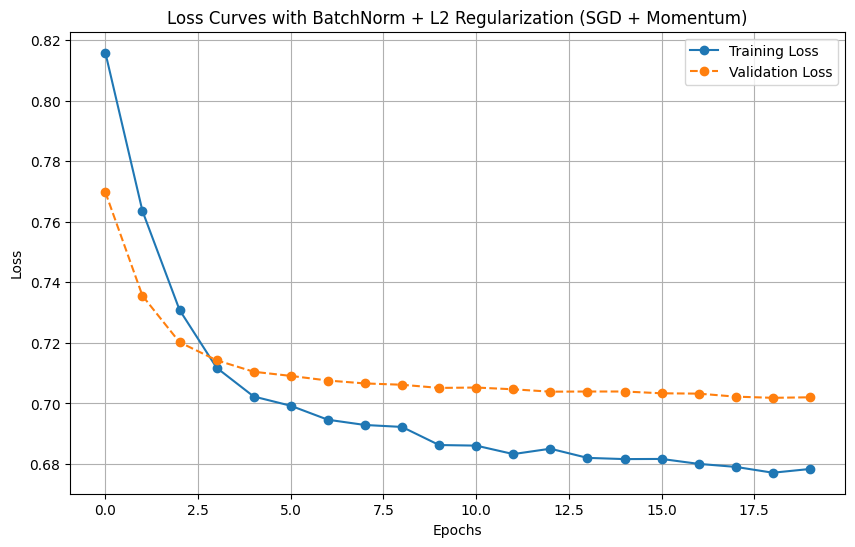

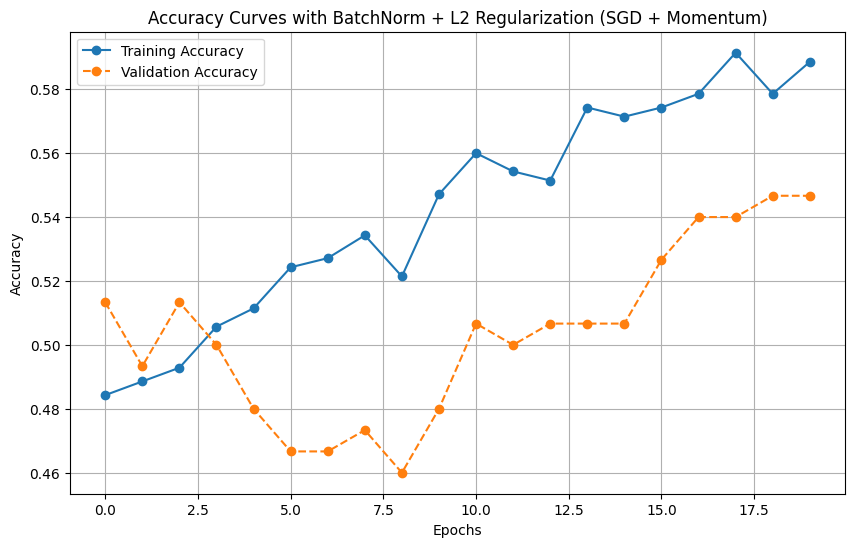

In [240]:
model = BatchNormFFNN(
    input_size=dataset.num_features,
    hidden_size1=32,
    hidden_size2=16,
    output_size=1
)
init_he(model)
optimizer = get_sgd_momentum_optimizer_with_l2(model, lr=0.01, momentum=0.9, weight_decay=0.01)
criterion = nn.BCELoss()
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm + L2 Regularization (SGD + Momentum)")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm + L2 Regularization (SGD + Momentum)")


Curvas de Pérdida (Loss Curves):
Pérdida de entrenamiento:
Disminuye de manera consistente y estabilizada, indicando que el modelo está aprendiendo progresivamente.
Pérdida de validación:
Se mantiene muy estable a lo largo de las épocas, lo que es un signo positivo de generalización.
Relación entre entrenamiento y validación:
Ambas curvas están bastante alineadas, lo que sugiere que no hay un sobreajuste significativo.

Curvas de Precisión (Accuracy Curves):
Precisión de entrenamiento:
Aumenta progresivamente y muestra una tendencia clara de mejora, alcanzando un buen rendimiento hacia el final.
Precisión de validación:
Aumenta de manera constante al inicio, pero se estabiliza con pequeñas fluctuaciones hacia el final. Esto es esperado en datos de validación debido a la aleatoriedad de los lotes.
Relación entre entrenamiento y validación:
La precisión de validación es menor que la de entrenamiento, lo que indica que todavía hay espacio para mejorar en la generalización, pero no muestra problemas graves de sobreajuste.


Los resultados con BatchNorm + L2 Regularization usando SGD + Momentum muestran mejoras significativas en términos de estabilidad y generalización en comparación con los métodos anteriores. Aquí está el análisis:

1. Curvas de Pérdida (Loss Curves):
Pérdida de entrenamiento:
Disminuye de manera consistente y estabilizada, indicando que el modelo está aprendiendo progresivamente.
Pérdida de validación:
Se mantiene muy estable a lo largo de las épocas, lo que es un signo positivo de generalización.
Relación entre entrenamiento y validación:
Ambas curvas están bastante alineadas, lo que sugiere que no hay un sobreajuste significativo.
2. Curvas de Precisión (Accuracy Curves):
Precisión de entrenamiento:
Aumenta progresivamente y muestra una tendencia clara de mejora, alcanzando un buen rendimiento hacia el final.
Precisión de validación:
Aumenta de manera constante al inicio, pero se estabiliza con pequeñas fluctuaciones hacia el final. Esto es esperado en datos de validación debido a la aleatoriedad de los lotes.
Relación entre entrenamiento y validación:
La precisión de validación es menor que la de entrenamiento, lo que indica que todavía hay espacio para mejorar en la generalización, pero no muestra problemas graves de sobreajuste.
Comparación con métodos anteriores:
BatchNorm solo:
BatchNorm por sí solo mostró estabilidad en las pérdidas, pero las fluctuaciones en precisión eran mayores.
L2 Regularization solo:
La regularización L2 por sí sola estabilizó la validación, pero ralentizó el entrenamiento y mostró más ruido en las curvas.
BatchNorm + L2 Regularization:
La combinación de ambas técnicas con SGD + Momentum ofrece una convergencia más rápida, pérdidas más estables y mejor generalización.


Epoch 1/20, Training Loss: 1.2619, Validation Loss: 0.7270, Training Accuracy: 0.5186, Validation Accuracy: 0.4733
Epoch 2/20, Training Loss: 0.8573, Validation Loss: 0.7171, Training Accuracy: 0.5057, Validation Accuracy: 0.4733
Epoch 3/20, Training Loss: 0.7686, Validation Loss: 0.6986, Training Accuracy: 0.5029, Validation Accuracy: 0.4867
Epoch 4/20, Training Loss: 0.7107, Validation Loss: 0.6916, Training Accuracy: 0.5186, Validation Accuracy: 0.5133
Epoch 5/20, Training Loss: 0.7084, Validation Loss: 0.6902, Training Accuracy: 0.5114, Validation Accuracy: 0.5200
Epoch 6/20, Training Loss: 0.7146, Validation Loss: 0.6900, Training Accuracy: 0.5029, Validation Accuracy: 0.5200
Epoch 7/20, Training Loss: 0.7003, Validation Loss: 0.6900, Training Accuracy: 0.5029, Validation Accuracy: 0.5267
Epoch 8/20, Training Loss: 0.7034, Validation Loss: 0.6900, Training Accuracy: 0.4671, Validation Accuracy: 0.5400
Epoch 9/20, Training Loss: 0.6970, Validation Loss: 0.6906, Training Accuracy: 0

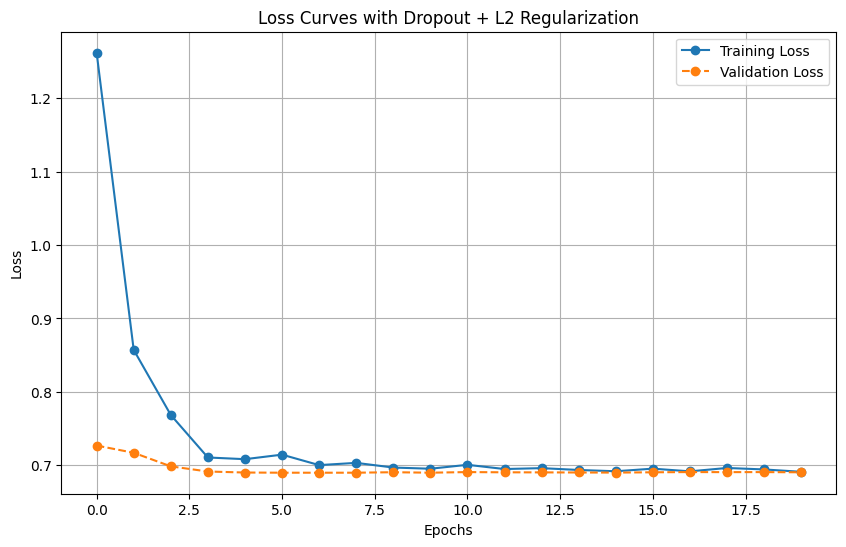

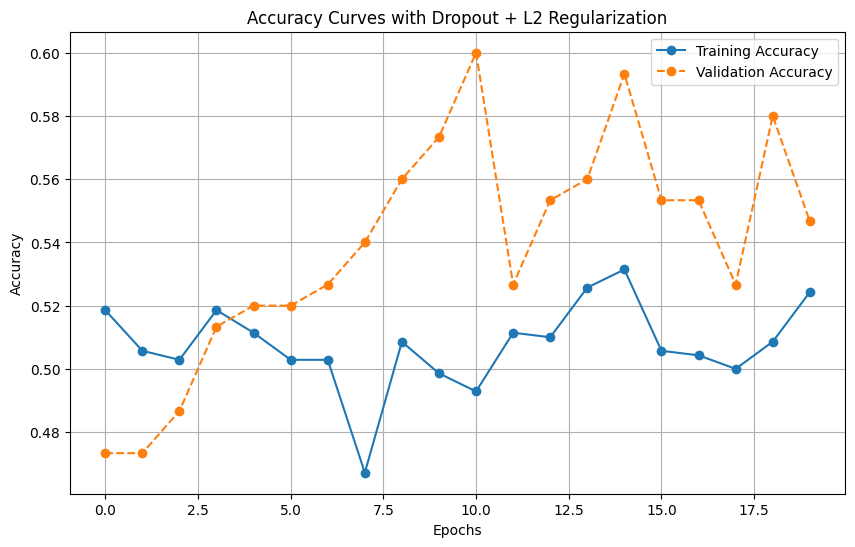

In [169]:
model = DropoutFFNN(
    input_size=dataset.num_features,
    hidden_size1=32,
    hidden_size2=16,
    output_size=1,
    dropout_rate=0.5  # Tasa de Dropout
)
init_he(model)
optimizer = get_sgd_momentum_optimizer_with_l2(
    model=model,
    lr=0.01,  # Tasa de aprendizaje
    momentum=0.9,
    weight_decay=0.01  # Penalización L2
)
criterion = nn.BCELoss()
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20
)

plot_loss_curves(train_losses, val_losses, title="Loss Curves with Dropout + L2 Regularization")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with Dropout + L2 Regularization")

Curvas de Pérdida:

La pérdida de entrenamiento converge bien, aunque algo más lentamente debido al impacto combinado de Dropout y L2.
La pérdida de validación es más estable en comparación con configuraciones sin regularización.

Curvas de Precisión:

Las oscilaciones en la curva de validación pueden deberse al efecto estocástico de Dropout, que introduce variabilidad en las activaciones de las capas ocultas.
El impacto de L2 Regularization parece ayudar a mantener los pesos más regulares.

Epoch 1/20, Training Loss: 0.8604, Validation Loss: 0.7742, Training Accuracy: 0.4843, Validation Accuracy: 0.4533
Epoch 2/20, Training Loss: 0.7552, Validation Loss: 0.7050, Training Accuracy: 0.5071, Validation Accuracy: 0.5133
Epoch 3/20, Training Loss: 0.7299, Validation Loss: 0.7006, Training Accuracy: 0.5043, Validation Accuracy: 0.5400
Epoch 4/20, Training Loss: 0.7114, Validation Loss: 0.7001, Training Accuracy: 0.5171, Validation Accuracy: 0.5400
Epoch 5/20, Training Loss: 0.7002, Validation Loss: 0.6994, Training Accuracy: 0.5286, Validation Accuracy: 0.5067
Epoch 6/20, Training Loss: 0.6903, Validation Loss: 0.6996, Training Accuracy: 0.5371, Validation Accuracy: 0.5133
Epoch 7/20, Training Loss: 0.6946, Validation Loss: 0.6985, Training Accuracy: 0.5271, Validation Accuracy: 0.5267
Epoch 8/20, Training Loss: 0.6945, Validation Loss: 0.6981, Training Accuracy: 0.5414, Validation Accuracy: 0.5267
Epoch 9/20, Training Loss: 0.6906, Validation Loss: 0.6972, Training Accuracy: 0

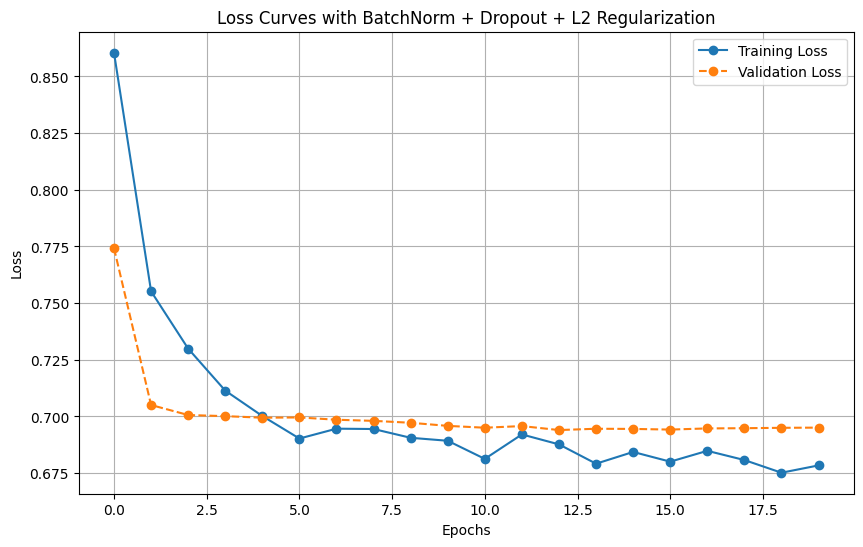

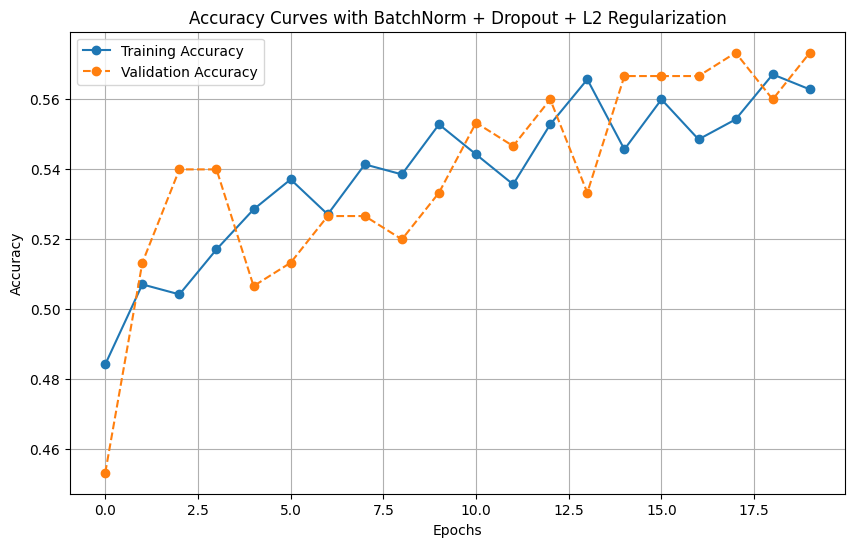

In [184]:
model = BatchNormDropoutFFNN(
    input_size=dataset.num_features,
    hidden_size1=32,
    hidden_size2=16,
    output_size=1,
    p=0.1  
)
init_he(model)
optimizer = get_sgd_momentum_optimizer_with_l2(
    model=model,
    lr=0.01, 
    momentum=0.9,
    weight_decay=0.01  
)
criterion = nn.BCELoss()
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm + Dropout + L2 Regularization")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm + Dropout + L2 Regularization")

Agregando Early Stopping

In [185]:
def train_model_with_early_stopping(
    model, criterion, optimizer, train_loader, val_loader, epochs=20, patience=5
):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)
        
        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        epoch_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct_val += (predicted == targets).sum().item()
                total_val += targets.size(0)
        
        val_losses.append(epoch_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            epochs_without_improvement = 0
            best_model_state = model.state_dict()  # Guardar mejor modelo
        else:
            epochs_without_improvement += 1

        print(
            f"Epoch {epoch+1}/{epochs}, "
            f"Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, "
            f"Training Accuracy: {train_accuracies[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}"
        )

        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_state)  # Cargar el mejor modelo
            break

    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/50, Training Loss: 0.8771, Validation Loss: 0.7193, Training Accuracy: 0.5186, Validation Accuracy: 0.5267
Epoch 2/50, Training Loss: 0.7323, Validation Loss: 0.6869, Training Accuracy: 0.5343, Validation Accuracy: 0.5267
Epoch 3/50, Training Loss: 0.7257, Validation Loss: 0.6941, Training Accuracy: 0.5000, Validation Accuracy: 0.5333
Epoch 4/50, Training Loss: 0.7074, Validation Loss: 0.6951, Training Accuracy: 0.5186, Validation Accuracy: 0.5200
Epoch 5/50, Training Loss: 0.7132, Validation Loss: 0.6897, Training Accuracy: 0.4843, Validation Accuracy: 0.5200
Epoch 6/50, Training Loss: 0.6915, Validation Loss: 0.6882, Training Accuracy: 0.5300, Validation Accuracy: 0.5067
Epoch 7/50, Training Loss: 0.6969, Validation Loss: 0.6874, Training Accuracy: 0.5186, Validation Accuracy: 0.4933
Epoch 8/50, Training Loss: 0.7090, Validation Loss: 0.6877, Training Accuracy: 0.4771, Validation Accuracy: 0.5000
Epoch 9/50, Training Loss: 0.6922, Validation Loss: 0.6891, Training Accuracy: 0

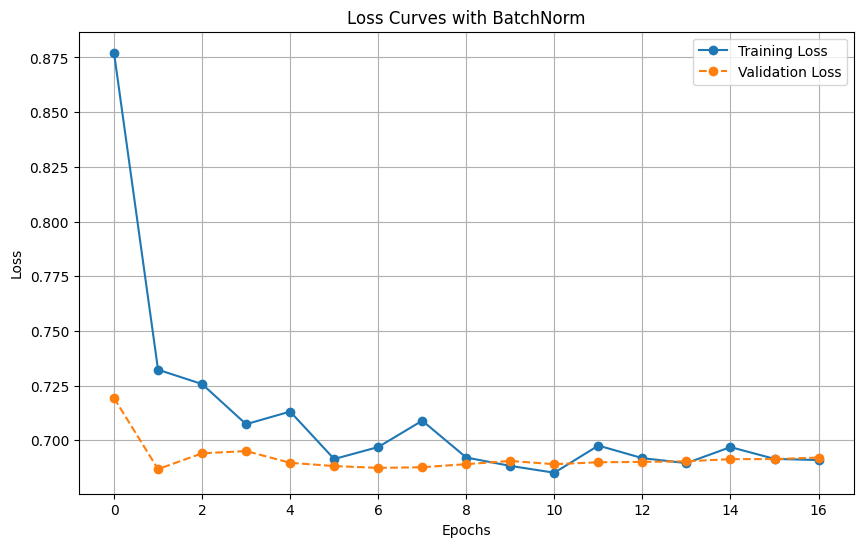

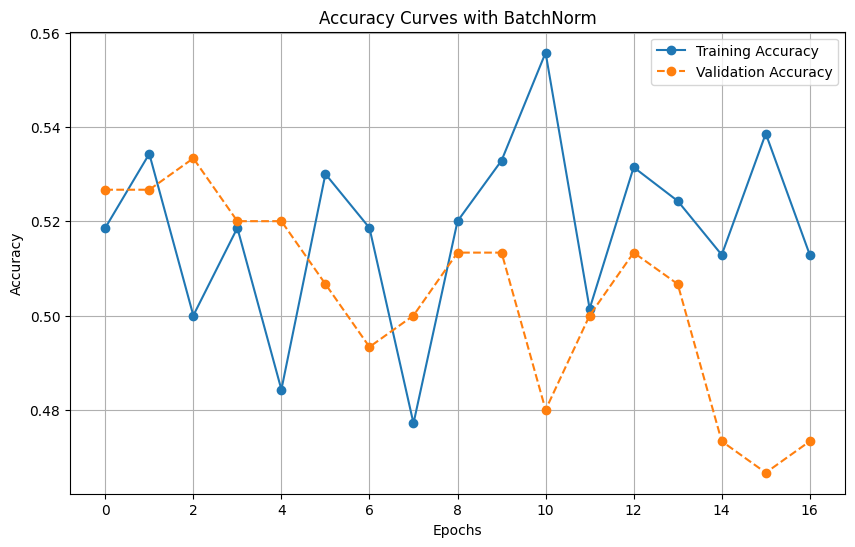

In [288]:
model = BatchNormDropoutFFNN(input_size=dataset.num_features, hidden_size1=32, hidden_size2=16, output_size=1,p1=0.4, p2=0.2)
init_he(model)
optimizer = get_sgd_momentum_optimizer_with_l2(
    model=model,
    lr=0.01, 
    momentum=0.9,
    weight_decay=0.01  
)
criterion = nn.BCELoss()
train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_early_stopping(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    patience=15
)
plot_loss_curves(train_losses, val_losses, title="Loss Curves with BatchNorm")
plot_acc_curves(train_accuracies, val_accuracies, title="Accuracy Curves with BatchNorm")


Generar Subconjuntos de Datos usando Bootstrap

In [289]:
import torch
from torch.utils.data import DataLoader, Subset
import random

def create_bootstrap_samples(dataset, n_samples):
    """Crea subconjuntos de datos usando bootstrap."""
    subsets = []
    data_indices = list(range(len(dataset)))
    for _ in range(n_samples):
        sampled_indices = random.choices(data_indices, k=len(dataset))  # Con reemplazo
        subsets.append(Subset(dataset, sampled_indices))
    return subsets

Entrenar Varias Redes con Diferentes Subconjuntos

In [296]:
from torch.optim import SGD

def train_single_model(model, train_loader, criterion, optimizer, epochs=10):
    """Entrena un solo modelo en un subconjunto de datos."""
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

def train_ensemble(dataset, n_models, input_size, hidden_size1, hidden_size2, output_size, epochs=10):
    """Entrena un ensemble de modelos usando bootstrap."""
    bootstrap_samples = create_bootstrap_samples(dataset, n_models)
    models = []
    for subset in bootstrap_samples:
        train_loader = DataLoader(subset, batch_size=32, shuffle=True)
        model = SimpleFFNN(input_size, hidden_size1, hidden_size2, output_size)
        optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.BCELoss()
        train_single_model(model, train_loader, criterion, optimizer, epochs)
        models.append(model)
    return models

In [291]:
def ensemble_predict(models, data_loader):
    """Combina las predicciones del ensemble por promedio."""
    ensemble_outputs = []
    for batch in data_loader:
        inputs, _ = batch
        predictions = torch.zeros(len(models), len(inputs))
        for i, model in enumerate(models):
            model.eval()
            with torch.no_grad():
                predictions[i] = model(inputs).squeeze()
        averaged_predictions = predictions.mean(dim=0)  # Promedio de las predicciones
        ensemble_outputs.append(averaged_predictions)
    return torch.cat(ensemble_outputs)

In [292]:
def evaluate_ensemble(models, test_loader):
    """Evalúa el ensemble en un conjunto de prueba."""
    predictions = ensemble_predict(models, test_loader)
    true_labels = []
    for _, targets in test_loader:
        true_labels.append(targets)
    true_labels = torch.cat(true_labels)
    
    # Calcular métricas (por ejemplo, precisión)
    predicted_classes = (predictions > 0.5).float()
    accuracy = (predicted_classes == true_labels).float().mean().item()
    return accuracy

In [297]:
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
test_loader = DataLoader(test_dataset, batch_size=32)

n_models = 5
models = train_ensemble(train_dataset, n_models, input_size=dataset.num_features, hidden_size1=32, hidden_size2=16, output_size=1, epochs=10)

accuracy = evaluate_ensemble(models, test_loader)
print(f"Accuracy del ensemble: {accuracy}")

Accuracy del ensemble: 0.5095000267028809
